## 📊 SciKG_Extract Quantitative Evaluations - ZnO and IGZO Extractions

#### ⚙️ Package Imports and Setup

In [1]:
# Append the parent directory to sys.path
import sys
sys.path.append("..")

In [2]:
# Python imports
import os
import json

# Scikg_Extract imports
from scikg_extract.utils.evaluation_utils import bert_score, rouge_score
from scikg_extract.utils.file_utils import read_json_file
from scikg_extract.utils.dict_utils import flatten_record

# Pandas import
import pandas as pd

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.metrics import precision_score, recall_score, f1_score

# RapidFuzz import
from rapidfuzz import fuzz

#### 📊 ALD Experimental Schema Statistics

In [3]:
def count_leaf_properties_detailed(schema, path="", exclude_structural=False, debug=False):
    """
    Count leaf properties in a JSON schema with detailed tracking.
    
    Args:
        schema: The schema object to traverse
        path: Current path for debugging
        exclude_structural: If True, exclude metadata fields like hasQuantityKind, sameAs, quantityKind
        debug: Print each leaf property found
    
    Returns:
        int: Count of leaf properties
    """
    count = 0
    
    # Skip if not a dictionary
    if not isinstance(schema, dict):
        return 0
    
    # If this has a "type" field, check if it's a leaf
    if "type" in schema:
        schema_type = schema["type"]
        
        # Leaf types that hold actual data
        if schema_type in ["string", "number", "boolean", "integer"]:
            # Skip structural/metadata fields if requested
            if exclude_structural:
                if any(path.endswith(meta) for meta in ["hasQuantityKind", "sameAs", "quantityKind"]):
                    return 0
            
            if debug:
                print(f"  {path} ({schema_type})")
            return 1
        
        # Object type - recurse into properties
        elif schema_type == "object":
            if "properties" in schema:
                for prop_name, prop_schema in schema["properties"].items():
                    new_path = f"{path}.{prop_name}" if path else prop_name
                    count += count_leaf_properties_detailed(prop_schema, new_path, exclude_structural, debug)
        
        # Array type - check items
        elif schema_type == "array":
            if "items" in schema:
                # For arrays, we count the properties in the item schema
                count += count_leaf_properties_detailed(schema["items"], f"{path}[*]", exclude_structural, debug)
    
    # If no type specified, check if it has properties (object-like)
    elif "properties" in schema:
        for prop_name, prop_schema in schema["properties"].items():
            new_path = f"{path}.{prop_name}" if path else prop_name
            count += count_leaf_properties_detailed(prop_schema, new_path, exclude_structural, debug)
    
    return count

In [4]:
schema_path = "../data/schemas/ALD-experimental/ALD-experimental-schema.json"
schema = read_json_file(schema_path)

# Count all leaf properties (excluding QUDT metadata)
total_leaves = count_leaf_properties_detailed(schema, exclude_structural=True)
print(f"Total leaf properties (excluding QUDT metadata): {total_leaves}")

# Count including metadata
total_with_metadata = count_leaf_properties_detailed(schema, exclude_structural=False)
print(f"Total leaf properties (including QUDT metadata): {total_with_metadata}")

# Let's also break down by major section
sections = {
    "aldSystem": count_leaf_properties_detailed(schema["properties"]["aldSystem"], exclude_structural=True),
    "reactantSelection": count_leaf_properties_detailed(schema["properties"]["reactantSelection"], exclude_structural=True),
    "processParameters": count_leaf_properties_detailed(schema["properties"]["processParameters"], exclude_structural=True),
    "materialProperties": count_leaf_properties_detailed(schema["properties"]["materialProperties"], exclude_structural=True),
    "deviceProperties": count_leaf_properties_detailed(schema["properties"]["deviceProperties"], exclude_structural=True),
    "otherAspects": count_leaf_properties_detailed(schema["properties"]["otherAspects"], exclude_structural=True)
}

print("\nBreakdown by section:")
for section, count in sections.items():
    print(f"{section}: {count}")

Total leaf properties (excluding QUDT metadata): 65
Total leaf properties (including QUDT metadata): 155

Breakdown by section:
aldSystem: 3
reactantSelection: 6
processParameters: 26
materialProperties: 22
deviceProperties: 5
otherAspects: 3


#### 📊🔬 Extraction Statistics - ZnO and IGZO

In [5]:
# Directory path containing extraction files for ZnO
zno_extraction_files = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase/ZnO"

# Directory path containing extraction files for IGZO
igzo_extraction_files = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase/IGZO"

# Directory path containing all extractions files
all_extraction_files = "../results/extracted-data/ALD/version2"

In [7]:
def load_extraction_files(extraction_files_path: str, llm_models: list[str]) -> dict:
    """
    Load extraction files from the specified directory for given LLM models.
    Args:
        extraction_files_path (str): Path to the directory containing extraction files.
        llm_models (list[str]): List of LLM model names to filter extraction files.
    Returns:
        dict: A dictionary containing extraction data organized by LLM model and filename.
    """
    # Dictionary to hold extraction data for each LLM model
    extraction_data_dict = {}

    # Walk through the extraction files directory
    for root, _, files in os.walk(extraction_files_path):
        
        # Skip if no files found
        if not files: continue

        # Extracting LLM model from the root path and filtering
        llm_model_in_path = root.split(os.sep)[-1]
        if llm_model_in_path not in llm_models: continue

        # Extracting category from the root path
        category_in_path = root.split(os.sep)[-2]

        # Iterating over files in the directory
        for file in files:
            
            # Skip non-JSON files
            if not file.endswith(".json"): continue
            
            # Read extraction data from JSON file
            file_path = os.path.join(root, file)
            extraction_data = read_json_file(file_path)
            if not extraction_data: continue

            # Filename without extension with category prefix
            filename_without_ext = f"{category_in_path}_{os.path.splitext(file)[0]}"

            # Store extraction data in the dictionary with LLM model and filename as keys
            if llm_model_in_path not in extraction_data_dict:
                extraction_data_dict[llm_model_in_path] = {}
            extraction_data_dict[llm_model_in_path][filename_without_ext] = extraction_data

    # Return the loaded extraction data
    return extraction_data_dict

In [8]:
def extraction_statistics(extraction_file_path: str, llm_models: list[str]) -> pd.DataFrame:
    """
    Calculate and return extraction statistics for each LLM model. The statistics include:
    - Total Processes Extracted
    - Average Processes per Paper
    - Maximum Processes in a Paper
    - Average Properties extracted per Process
    Args:
        extraction_file_path (str): Path to the directory containing extraction files.
        llm_models (list[str]): List of LLM model names to filter extraction files.
    Returns:
        pd.DataFrame: A DataFrame containing extraction statistics for each LLM model.
    """

    # Read the extracted information
    extracted_data = load_extraction_files(extraction_file_path, llm_models)
    
    # Rows list for statistics DataFrame
    df_rows = []

    # Calculate statistics for each LLM model
    for llm, data in extracted_data.items():
        
        # Initialize statistics variables
        total_processes = 0
        process_counts = []
        properties_per_process = []

        # Iterate over each file's extraction data
        for _, extraction in data.items():
            
            # Get processes from the extraction data
            processes = extraction.get("processes", [])
            num_processes = len(processes)
            total_processes += num_processes
            process_counts.append(num_processes)

            # Calculate all leaf properties for each process
            for process in processes:
                
                # Flatten the process dictionary
                flatten_process = flatten_record(process)

                # Remove the properties with QUDT information
                qudt_properties_to_remove = ["hasQuantityKind", "unit.sameAs", "quantityKind"]
                flatten_process = [(k, v) for k, v in flatten_process for remove_key in qudt_properties_to_remove if remove_key not in k]

                # Remove empty or null values
                flatten_process = [(k, v) for k, v in flatten_process if v not in [None, "", "Not Found", [], {}]]
                
                # Count the number of properties in the flattened process
                properties_per_process.append(len(flatten_process))

        # Calculate statistics
        avg_processes_per_paper = total_processes / len(data) if data else 0
        max_processes_in_paper = max(process_counts) if process_counts else 0
        avg_properties_per_process = sum(properties_per_process) / len(properties_per_process) if properties_per_process else 0

        # Append statistics to the rows list
        df_rows.append({
            "LLM": llm,
            "Total Process Extracted": total_processes,
            "Avg. Processes (Paper)": round(avg_processes_per_paper, 2),
            "Max. Processes (Paper)": max_processes_in_paper,
            "Avg. Properties (Process)": round(avg_properties_per_process, 2)
        })

    # DataFrame to hold extraction statistics
    columns = ["LLM", "Total Process Extracted", "Avg. Processes (Paper)", "Max. Processes (Paper)", "Avg. Properties (Process)"]
    stats_df = pd.DataFrame(df_rows, columns=columns)
    
    # Return the statistics DataFrame
    return stats_df

In [9]:
# LLM models used for extractions
llm_models_used = ["gpt-4o", "mistral-large-instruct", "qwen3-30b-a3b-instruct-2507", "qwen3-235b-a22b"]

# Calculate extraction statistics for ZnO
zno_stats_df = extraction_statistics(zno_extraction_files, llm_models_used)
zno_stats_df

,LLM,Total Process Extracted,Avg. Processes (Paper),Max. Processes (Paper),Avg. Properties (Process)
0,gpt-4o,181,1.12,4,205.20
1,mistral-large-instruct,192,1.19,4,255.59
2,qwen3-235b-a22b,196,1.21,4,304.74
3,qwen3-30b-a3b-instruct-2507,174,1.07,3,382.03


In [10]:
# Calculate extraction statistics for IGZO
igzo_stats_df = extraction_statistics(igzo_extraction_files, llm_models_used)
igzo_stats_df

,LLM,Total Process Extracted,Avg. Processes (Paper),Max. Processes (Paper),Avg. Properties (Process)
0,gpt-4o,79,1.10,3,266.59
1,mistral-large-instruct,76,1.06,3,378.04
2,qwen3-235b-a22b,75,1.04,3,470.40
3,qwen3-30b-a3b-instruct-2507,72,1.00,1,528.71


In [11]:
# Calculate extraction statistics for all files
all_stats_df = extraction_statistics(all_extraction_files, llm_models_used)
all_stats_df

,LLM,Total Process Extracted,Avg. Processes (Paper),Max. Processes (Paper),Avg. Properties (Process)
0,gpt-4o,333,1.12,4,231.99
1,mistral-large-instruct,331,1.12,4,312.21
2,qwen3-235b-a22b,333,1.12,4,343.20
3,qwen3-30b-a3b-instruct-2507,299,1.05,3,423.63


#### 🤖 Extracted Information Similarity Comparisons between different LLM Models

In [12]:
def compare_extractions_similarity_between_models(extraction_files_path: str, llm_models: list[str]) -> dict:
    """
    Compare the similarity of extractions between different LLM models using similarity metrics: BERTScore, ROUGE, and BLEU.
    Args:
        extraction_files_path (str): Path to the directory containing extraction JSON files.
        llm_models (list[str]): List of LLM model names to compare.
    Returns:
        dict: A dictionary containing similarity scores between model pairs.
    """
    # Read the extraction files
    extraction_data = load_extraction_files(extraction_files_path, llm_models)
    print(f"Loaded extraction data for LLM models: {list(extraction_data.keys())}")

    # BERT Embedding model
    bert_embedding_model = "allenai/scibert_scivocab_uncased"
    bert_embedding_model_revision = "24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1"
    print(f"Using BERT embedding model: {bert_embedding_model} (revision: {bert_embedding_model_revision})")

    # Dictionary to hold similarity scores
    similarity_scores = {}

    # Compare extractions between each pair of LLM models
    for llm in llm_models:
        print(f"Comparing extractions for LLM model: {llm}")

        # Dictionary to hold list of ground truth and predicted extractions
        extraction_dict = {"ground_truth": [], "predicted": []}

        for other_llm, value in extraction_data.items():
            
            # Skip comparison with the same model
            if llm == other_llm: continue

            # Check if similar combinations have already been compared
            if other_llm in similarity_scores and llm in similarity_scores[other_llm]:
                print(f"Skipping comparison between {llm} and {other_llm} as it has already been done.")
                continue 
            print(f"Now comparing {llm} with model: {other_llm}")

            # Iterate over filenames and their extractions
            for filename, predicted_extraction in value.items():

                # Get ground truth and predicted extractions
                ground_truth_extraction = extraction_data[llm].get(filename.split("_")[1], {})
                if not ground_truth_extraction: continue

                # Append the extractions to the lists
                extraction_dict["ground_truth"].append(str(ground_truth_extraction))
                extraction_dict["predicted"].append(str(predicted_extraction))

            # Calculate similarity scores
            bertscore = bert_score(extraction_dict["ground_truth"], extraction_dict["predicted"], embedding_model=bert_embedding_model, embedding_model_revision=bert_embedding_model_revision)
            rougescore = rouge_score(extraction_dict["ground_truth"], extraction_dict["predicted"])
            print(f"RougeL Score between {llm} and {other_llm}: {rougescore['rougeL']}")
            print(f"BERTScore F1 between {llm} and {other_llm}: {bertscore['f1']}")

            # Store similarity scores in the dictionary
            if llm not in similarity_scores:
                similarity_scores[llm] = {}
            similarity_scores[llm][other_llm] = {"bertscore": bertscore, "rougescore": rougescore}

    # Return the similarity scores
    return similarity_scores

In [ ]:
# Compare extractions similarity between models for ZnO
similarity_score = compare_extractions_similarity_between_models(zno_extraction_files, llm_models_used)

In [ ]:
# Compare extractions similarity between models for IGZO
similarity_score_igzo = compare_extractions_similarity_between_models(igzo_extraction_files, llm_models_used)

In [40]:
# Duplicate scores for reverse comparisons
for llm, comparisons in list(similarity_score.items()):
    for other_llm, scores in comparisons.items():
        if other_llm not in similarity_score:
            similarity_score[other_llm] = {}
        similarity_score[other_llm][llm] = scores

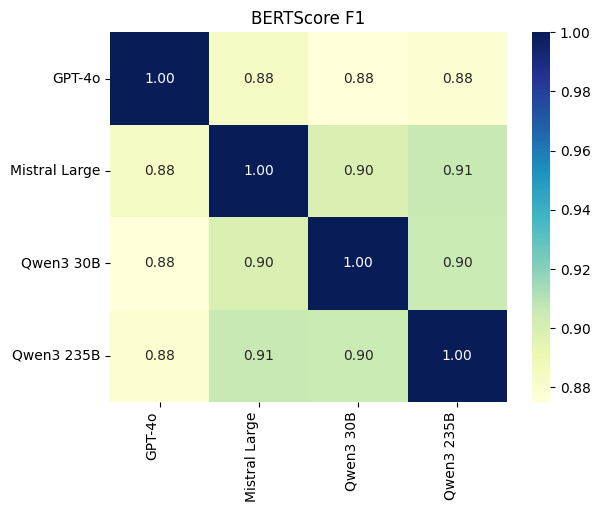

In [53]:
# LLM name mapping for better visualization
llm_name_mapping = {
    "gpt-4o": "GPT-4o",
    "mistral-large-instruct": "Mistral Large",
    "qwen3-30b-a3b-instruct-2507": "Qwen3 30B",
    "qwen3-235b-a22b": "Qwen3 235B"
}

# Prepare data for heatmap
llm_models = list(similarity_score.keys())

# Map LLM names for better visualization
llm_models = [llm_name_mapping.get(llm, llm) for llm in llm_models]

# Create a DataFrame for heatmap
heatmap_data = pd.DataFrame(index=llm_models, columns=llm_models)

for llm, comparisons in similarity_score.items():
    for other_llm, scores in comparisons.items():
        heatmap_data.at[llm_name_mapping[llm], llm_name_mapping[other_llm]] = scores["bertscore"]["f1"]

# Fill diagonal with 1.0 (self-comparison)
for llm in llm_models:
    heatmap_data.at[llm, llm] = 1.0
        
# Convert data to numeric
heatmap_data = heatmap_data.astype(float)

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("BERTScore F1")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.show()

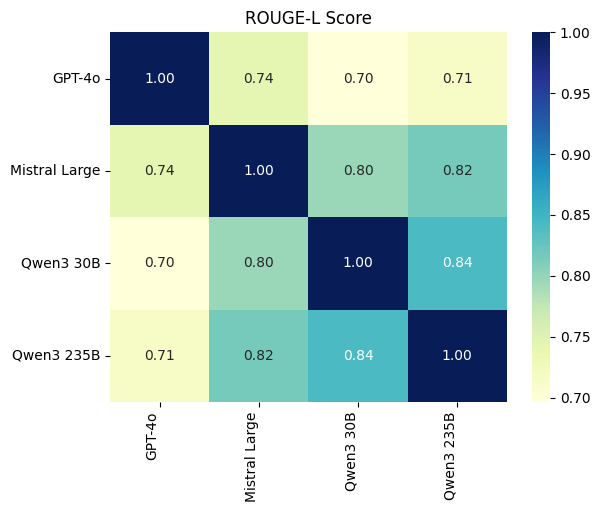

In [49]:
# Prepare data for heatmap
llm_models = list(similarity_score.keys())

# Map LLM names for better visualization
llm_models = [llm_name_mapping.get(llm, llm) for llm in llm_models]

# Create a DataFrame for heatmap
heatmap_data = pd.DataFrame(index=llm_models, columns=llm_models)

for llm, comparisons in similarity_score.items():
    for other_llm, scores in comparisons.items():
        heatmap_data.at[llm_name_mapping[llm], llm_name_mapping[other_llm]] = scores["rougescore"]["rougeL"]

# Fill diagonal with 1.0 (self-comparison)
for llm in llm_models:
    heatmap_data.at[llm, llm] = 1.0
        
# Convert data to numeric
heatmap_data = heatmap_data.astype(float)

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ROUGE-L Score")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.show()

#### ⚖️ LLM-as-a-Judge Evaluations

In [13]:
def calculate_average_metric(evaluation_results_path: str) -> None:
    """
    Calculate the average completeness and correctness score from evaluation results stored in JSON files.
    Args:
        evaluation_results_path (str): Path to the directory containing evaluation result JSON files.
    """
    total_completeness = 0.0
    total_correctness = 0.0
    max_completeness = 0.0
    max_correctness = 0.0
    file_count = 0

    # Dictionary to hold evaluation results by LLMs
    evaluation_results_dict = {}

    # Walk through the evaluation results directory
    for root, _, files in os.walk(evaluation_results_path):
        
        # Iterate over each file in the directory
        for file in files:
            
            # Process only JSON files
            if not file.endswith(".json"): continue
            
            # Extract extraction LLM and evaluation LLM from the root path
            extraction_llm = root.split(os.sep)[-2]
            evaluation_llm = root.split(os.sep)[-1]
            if evaluation_llm != "gpt-5": continue
            if extraction_llm == "llama-3.3-70b-instruct" or extraction_llm == "qwen3-30b-a3b-thinking-2507": continue
            
            # Read evaluation result from JSON file
            file_path = os.path.join(root, file)
            evaluation_result = read_json_file(file_path)

            # Check if evaluation result is valid
            if not evaluation_result: continue

            # Extract completeness score and accumulate
            completeness_score = float(evaluation_result.get("completeness", {}).get("rating", 0.0))
            correctness_score = float(evaluation_result.get("correctness", {}).get("rating", 0.0))

            # Store evaluation results in the dictionary
            if extraction_llm not in evaluation_results_dict:
                evaluation_results_dict[extraction_llm] = {
                    "completeness_score": completeness_score,
                    "correctness_score": correctness_score,
                    "max_completeness": completeness_score,
                    "max_correctness": correctness_score,
                    "file_count": 1
                }
            else:
                evaluation_results_dict[extraction_llm]["completeness_score"] += completeness_score
                evaluation_results_dict[extraction_llm]["correctness_score"] += correctness_score
                if completeness_score > evaluation_results_dict[extraction_llm]["max_completeness"]:
                    evaluation_results_dict[extraction_llm]["max_completeness"] = completeness_score
                if correctness_score > evaluation_results_dict[extraction_llm]["max_correctness"]:
                    evaluation_results_dict[extraction_llm]["max_correctness"] = correctness_score
                evaluation_results_dict[extraction_llm]["file_count"] += 1

            # Accumulate scores
            total_completeness += completeness_score
            total_correctness += correctness_score
            if completeness_score > max_completeness:
                max_completeness = completeness_score
            if correctness_score > max_correctness:
                max_correctness = correctness_score
            file_count += 1

    # Calculate and print average scores by LLMs
    for llm, scores in evaluation_results_dict.items():
        avg_completeness = scores["completeness_score"] / scores["file_count"] if scores["file_count"] > 0 else 0.0
        avg_correctness = scores["correctness_score"] / scores["file_count"] if scores["file_count"] > 0 else 0.0
        print(f"LLM: {llm} | Average Completeness Score: {avg_completeness:.2f} | Average Correctness Score: {avg_correctness:.2f} | Max Completeness: {scores['max_completeness']:.2f} | Max Correctness: {scores['max_correctness']:.2f}")

    # Calculate average completeness score
    average_completeness = total_completeness / file_count if file_count > 0 else 0.0
    average_correctness = total_correctness / file_count if file_count > 0 else 0.0
    print(f"Average Completeness Score: {average_completeness:.2f}")
    print(f"Average Correctness Score: {average_correctness:.2f}")
    print(f"Maximum Completeness Score: {max_completeness:.2f}")
    print(f"Maximum Correctness Score: {max_correctness:.2f}")

In [14]:
evaluation_results_path = "../results/evaluation/ALD/version2/ZnO-IGZO-papers/experimental-usecase/ZnO"
print("ZnO Evaluation Results:")
calculate_average_metric(evaluation_results_path)

evaluation_results_path = "../results/evaluation/ALD/version2/ZnO-IGZO-papers/experimental-usecase/IGZO"
print("\nIGZO Evaluation Results:")
calculate_average_metric(evaluation_results_path)

evaluation_results_path = "../results/evaluation/ALD/version2/ZnO-IGZO-papers/experimental-usecase"
print("\nOverall Evaluation Results:")
calculate_average_metric(evaluation_results_path)

ZnO Evaluation Results:
LLM: gpt-4o | Average Completeness Score: 1.15 | Average Correctness Score: 1.20 | Max Completeness: 2.00 | Max Correctness: 2.00
LLM: mistral-large-instruct | Average Completeness Score: 1.17 | Average Correctness Score: 1.13 | Max Completeness: 2.00 | Max Correctness: 2.00
LLM: qwen3-235b-a22b | Average Completeness Score: 1.23 | Average Correctness Score: 1.27 | Max Completeness: 2.00 | Max Correctness: 2.00
LLM: qwen3-30b-a3b-instruct-2507 | Average Completeness Score: 1.07 | Average Correctness Score: 1.15 | Max Completeness: 2.00 | Max Correctness: 2.00
Average Completeness Score: 1.16
Average Correctness Score: 1.19
Maximum Completeness Score: 2.00
Maximum Correctness Score: 2.00

IGZO Evaluation Results:
LLM: gpt-4o | Average Completeness Score: 1.25 | Average Correctness Score: 1.36 | Max Completeness: 2.00 | Max Correctness: 2.00
LLM: mistral-large-instruct | Average Completeness Score: 1.24 | Average Correctness Score: 1.28 | Max Completeness: 2.00 | 

#### 🆚 Comparison with AtomicLimits Database

In [65]:
def compare_atomic_limits_annotations_without_normalization(extraction_file_path: str, llm_models: list[str]) -> None:

    # Dictionary to hold values for material deposited, precursors and co-reactants
    extraction_values = {
        "material_deposited": {"references": [], "predictions": []},
        "precursors": {"references": [], "predictions": []},
        "co_reactants": {"references": [], "predictions": []}
    }

    for root, _, files in os.walk(extraction_file_path):

        # skip if no files found
        if not files: continue
        
        # Extracting LLM model from the root path and filtering
        llm_model_in_path = root.split(os.sep)[-1]
        if llm_model_in_path not in llm_models: continue

        # Extract material deposited from the root path
        material_deposited_atomic_limits = root.split(os.sep)[-4]
        if material_deposited_atomic_limits not in ["ZnO", "IGZO"]:
            material_deposited_atomic_limits = root.split(os.sep)[-3]
        
        # Extracting atomicLimits annotations from the root path
        annotations = root.split(os.sep)[-2].split("-")
        annotations = [an.strip() for an in annotations]
        
        for file in files:

            # skip non-JSON files
            if not file.endswith(".json"): continue

            # Read extraction data from JSON file
            file_path = os.path.join(root, file)
            extraction_data = read_json_file(file_path)
            if not extraction_data: 
                print(f"Warning: No data found in {file_path}, skipping.")
                continue

            # Iterate over each process
            for process in extraction_data.get("processes", []):
                # Extract Material Deposited
                material_deposited = process.get("aldSystem", {}).get("materialDeposited", "")
                extraction_values["material_deposited"]["predictions"].append(material_deposited)
                extraction_values["material_deposited"]["references"].append(material_deposited_atomic_limits)

                # Extract Precursors
                precursor = process.get("reactantSelection", {}).get("precursor", [])
                for prec in precursor:
                    prec_name = prec.get("precursor", "")
                    if len(annotations) > 1:
                        extraction_values["precursors"]["predictions"].append(prec_name)
                        extraction_values["precursors"]["references"].append(annotations[0])

                # Extract Co-Reactants
                coreactant = process.get("reactantSelection", {}).get("coReactant", [])
                for index, coreac in enumerate(coreactant):
                    coreac_name = coreac.get("coReactant", "")
                    if index + 1 < len(annotations):
                        extraction_values["co_reactants"]["predictions"].append(coreac_name)
                        extraction_values["co_reactants"]["references"].append(annotations[index + 1])

    # Calculate precision, recall, F1-score and BERTScore for each category
    for category, values in extraction_values.items():
        references = values["references"]
        predictions = values["predictions"]

        precision = precision_score(references, predictions, average='weighted', zero_division=0)
        recall = recall_score(references, predictions, average='weighted', zero_division=0)
        f1 = f1_score(references, predictions, average='weighted', zero_division=0)
        bertscore = bert_score(references, predictions, embedding_model="allenai/scibert_scivocab_uncased", embedding_model_revision="24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1")

        print(f"Category: {category}")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall:    {recall:.2f}")
        print(f"  F1-Score:  {f1:.2f}")
        print(f"  BERTScore Precision: {bertscore['precision']:.2f}")
        print(f"  BERTScore Recall:    {bertscore['recall']:.2f}")
        print(f"  BERTScore F1: {bertscore['f1']:.2f}\n")

In [69]:
zno_igzo_extraction_file = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase"
compare_atomic_limits_annotations_without_normalization(zno_igzo_extraction_file, ["qwen3-235b-a22b"])

Category: material_deposited
  Precision: 1.00
  Recall:    0.82
  F1-Score:  0.89
  BERTScore Precision: 0.94
  BERTScore Recall:    0.95
  BERTScore F1: 0.94

Category: precursors
  Precision: 0.02
  Recall:    0.02
  F1-Score:  0.02
  BERTScore Precision: 0.65
  BERTScore Recall:    0.66
  BERTScore F1: 0.65

Category: co_reactants
  Precision: 0.63
  Recall:    0.43
  F1-Score:  0.50
  BERTScore Precision: 0.83
  BERTScore Recall:    0.81
  BERTScore F1: 0.82



In [70]:
def find_best_matching_cid(value: str, cid_mapping: dict) -> str:
    """
    Finds the best matching PubChem CID for a given property value using the provided mapping.
    Args:
        value (str): The property value to find a CID for.
        cid_mapping (dict): A dictionary mapping property values to PubChem CIDs.
    Returns:
        str: The best matching PubChem CID(s) as a comma-separated string, or an empty string if not found.
    """
    # Check for exact match first
    if value in cid_mapping:
        return cid_mapping[value]

    # Initialize variables for fuzzy matching
    max_score = -1
    best_cid = ""

    # Iterate over the mapping to find the best fuzzy match
    for syn, cid in cid_mapping.items():
        # Check for substring match
        if value.lower() in syn.lower():
            score = 100
        else:
            score = fuzz.ratio(value, syn)
        
        # If score is still less than 85, check for token set ratio
        if score < 85:
            score = fuzz.token_set_ratio(value, syn)

        # Update best match if current score is higher
        if score > max_score and score >= 85:
            max_score = score
            best_cid = cid
    
    # Return the best matching CID(s) or empty string if not found
    return best_cid

In [71]:
def compare_atomic_limits_annotations_with_normalization(extraction_file_path: str, llm_models: list[str], normalization_mapping: dict[str, str]) -> None:

    # Dictionary to hold values for material deposited, precursors and co-reactants
    extraction_values = {
        "material_deposited": {"references": [], "predictions": []},
        "precursors": {"references": [], "predictions": []},
        "co_reactants": {"references": [], "predictions": []}
    }

    for root, _, files in os.walk(extraction_file_path):

        # skip if no files found
        if not files: continue
        
        # Extracting LLM model from the root path and filtering
        llm_model_in_path = root.split(os.sep)[-1]
        if llm_model_in_path not in llm_models: continue

        # Extract material deposited from the root path
        material_deposited_atomic_limits = root.split(os.sep)[-4]
        if material_deposited_atomic_limits not in ["ZnO", "IGZO"]:
            material_deposited_atomic_limits = root.split(os.sep)[-3]
        
        # Extracting atomicLimits annotations from the root path
        annotations = root.split(os.sep)[-2].split("-" if material_deposited_atomic_limits == "IGZO" else " - ")
        annotations = [an.strip() for an in annotations]
        
        # Check if normalization mapping exists for all annotations
        for file in files:

            # skip non-JSON files
            if not file.endswith(".json"): continue

            # Read extraction data from JSON file
            file_path = os.path.join(root, file)
            extraction_data = read_json_file(file_path)
            if not extraction_data: 
                print(f"Warning: No data found in {file_path}, skipping.")
                continue

            # Iterate over each process
            for process in extraction_data.get("processes", []):
                
                # Extract Material Deposited
                material_deposited = process.get("aldSystem", {}).get("materialDeposited", "")

                # Normalize Material Deposited
                cid_groundTruth = find_best_matching_cid(material_deposited_atomic_limits, normalization_mapping)
                cid_prediction = find_best_matching_cid(material_deposited, normalization_mapping)

                if cid_groundTruth and cid_prediction:
                    extraction_values["material_deposited"]["predictions"].append(f"{material_deposited} [CID: {cid_prediction}]")
                    extraction_values["material_deposited"]["references"].append(f"{material_deposited_atomic_limits} [CID: {cid_groundTruth}]")

                # Extract Precursors
                precursor = process.get("reactantSelection", {}).get("precursor", [])
                for prec in precursor:
                    prec_name = prec.get("precursor", "")
                    if len(annotations) > 1:
                        # Normalize Precursors
                        cid_groundTruth = find_best_matching_cid(annotations[0], normalization_mapping)
                        cid_prediction = find_best_matching_cid(prec_name, normalization_mapping)
                        if cid_groundTruth and cid_prediction:
                            extraction_values["precursors"]["predictions"].append(f"{prec_name} [CID: {cid_prediction}]")
                            extraction_values["precursors"]["references"].append(f"{annotations[0]} [CID: {cid_groundTruth}]")

                # Extract Co-Reactants
                coreactant = process.get("reactantSelection", {}).get("coReactant", [])
                for index, coreac in enumerate(coreactant):
                    coreac_name = coreac.get("coReactant", "")
                    if index + 1 < len(annotations):
                        # Normalize Co-Reactants
                        cid_groundTruth = find_best_matching_cid(annotations[index + 1], normalization_mapping)
                        cid_prediction = find_best_matching_cid(coreac_name, normalization_mapping)
                        if cid_groundTruth and cid_prediction:
                            extraction_values["co_reactants"]["predictions"].append(f"{coreac_name} [CID: {cid_prediction}]")
                            extraction_values["co_reactants"]["references"].append(f"{annotations[index + 1]} [CID: {cid_groundTruth}]")

    # Calculate precision, recall, F1-score and BERTScore for each category
    for category, values in extraction_values.items():
        references = values["references"]
        predictions = values["predictions"]

        precision = precision_score(references, predictions, average='weighted', zero_division=0)
        recall = recall_score(references, predictions, average='weighted', zero_division=0)
        f1 = f1_score(references, predictions, average='weighted', zero_division=0)
        bertscore = bert_score(references, predictions, embedding_model="allenai/scibert_scivocab_uncased", embedding_model_revision="24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1")

        print(f"Category: {category}")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall:    {recall:.2f}")
        print(f"  F1-Score:  {f1:.2f}")
        print(f"  BERTScore Precision: {bertscore['precision']:.2f}")
        print(f"  BERTScore Recall:    {bertscore['recall']:.2f}")
        print(f"  BERTScore F1: {bertscore['f1']:.2f}\n")

In [75]:
# Read normalization mapping from JSON file
normalization_mapping_path = "../data/resources/PubChem-Synonym-CID.json"
normalization_mapping = read_json_file(normalization_mapping_path)

compare_atomic_limits_annotations_with_normalization(zno_igzo_extraction_file, ["qwen3-235b-a22b"], normalization_mapping)

Category: material_deposited
  Precision: 1.00
  Recall:    0.97
  F1-Score:  0.98
  BERTScore Precision: 0.99
  BERTScore Recall:    0.99
  BERTScore F1: 0.99

Category: precursors
  Precision: 0.03
  Recall:    0.03
  F1-Score:  0.03
  BERTScore Precision: 0.84
  BERTScore Recall:    0.86
  BERTScore F1: 0.85

Category: co_reactants
  Precision: 0.65
  Recall:    0.45
  F1-Score:  0.52
  BERTScore Precision: 0.92
  BERTScore Recall:    0.90
  BERTScore F1: 0.91



In [226]:
def compare_atomic_limits_annotations_with_normalization_accuracy(extraction_file_path: str, llm_models: list[str], normalization_mapping: dict[str, str]) -> None:

    # Dictionary to hold values for material deposited, precursors and co-reactants
    extraction_values = {
        "material_deposited": {"references": [], "predictions": []},
        "precursors": {"references": [], "predictions": []},
        "co_reactants": {"references": [], "predictions": []}
    }

    for root, _, files in os.walk(extraction_file_path):

        # skip if no files found
        if not files: continue
        
        # Extracting LLM model from the root path and filtering
        llm_model_in_path = root.split(os.sep)[-1]
        if llm_model_in_path not in llm_models: continue
        
        # Extract material deposited from the root path
        material_deposited_atomic_limits = root.split(os.sep)[0].split("/")[-2]
        if material_deposited_atomic_limits not in ["ZnO", "IGZO"]:
            material_deposited_atomic_limits = root.split(os.sep)[-3]
        
        # Extracting atomicLimits annotations from the root path
        annotations = root.split("/")[-1].split(os.sep)[-2].split("-" if material_deposited_atomic_limits == "IGZO" else " - ")
        annotations = [an.strip() for an in annotations]
        
        if material_deposited_atomic_limits == "IGZO":
            if annotations[0] == "In":
                annotations = ["In-Ga bimetallic single precursor", "ZnEt2", "O3"]
        
        # Skip check if present in Others category
        if "Others" in annotations: continue

        # Check if normalization mapping exists for all annotations
        for file in files:

            # skip non-JSON files
            if not file.endswith(".json"): continue

            # Read extraction data from JSON file
            file_path = os.path.join(root, file)
            extraction_data = read_json_file(file_path)
            if not extraction_data: 
                print(f"Warning: No data found in {file_path}, skipping.")
                continue

            # Iterate over each process
            for process in extraction_data.get("processes", []):
                
                # Extract Material Deposited
                material_deposited = process.get("aldSystem", {}).get("materialDeposited", "")

                # Normalize Material Deposited
                cid_groundTruth = find_best_matching_cid(material_deposited_atomic_limits, normalization_mapping)
                cid_prediction = find_best_matching_cid(material_deposited, normalization_mapping)

                if cid_groundTruth and cid_prediction:
                    extraction_values["material_deposited"]["predictions"].append(cid_prediction)
                    extraction_values["material_deposited"]["references"].append(cid_groundTruth)

                # Extract Precursors
                precursor = process.get("reactantSelection", {}).get("precursor", [])
                for prec in precursor:
                    prec_name = prec.get("precursor", "")
                    if len(annotations) > 1:
                        # Normalize Precursors
                        cid_groundTruth = find_best_matching_cid(annotations[0], normalization_mapping)
                        cid_prediction = find_best_matching_cid(prec_name, normalization_mapping)
                        if cid_groundTruth and cid_prediction:
                            extraction_values["precursors"]["predictions"].append(cid_prediction)
                            extraction_values["precursors"]["references"].append(cid_groundTruth)

                # Extract Co-Reactants
                coreactant = process.get("reactantSelection", {}).get("coReactant", [])
                for index, coreac in enumerate(coreactant):
                    coreac_name = coreac.get("coReactant", "")
                    if index + 1 < len(annotations):
                        # Normalize Co-Reactants
                        cid_groundTruth = find_best_matching_cid(annotations[index + 1], normalization_mapping)
                        cid_prediction = find_best_matching_cid(coreac_name, normalization_mapping)
                        if cid_groundTruth and cid_prediction:
                            extraction_values["co_reactants"]["predictions"].append(cid_prediction)
                            extraction_values["co_reactants"]["references"].append(cid_groundTruth)

    # Calculate accuracy for each category
    for category, values in extraction_values.items():
        references = values["references"]
        predictions = values["predictions"]

        accuracy = sum(1 for ref, pred in zip(references, predictions) if ref == pred) / len(references) if references else 0.0

        print(f"Category: {category}")
        print(f"Accuracy: {accuracy:.2f}\n")

In [ ]:
zno_extraction_files_normalized = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase/IGZO/AtomicLimits Database"
compare_atomic_limits_annotations_with_normalization_accuracy(zno_extraction_files_normalized, ["qwen3-30b-a3b-instruct-2507"], normalization_mapping)

#### 🧬 PubChem Normalization Statistics

In [62]:
def pubchem_normalization_stats(extraction_file_path: str, llm_models: list[str]) -> None:

    # Load extraction files
    extraction_data = load_extraction_files(extraction_file_path, llm_models)

    # Dictionary to hold normalization statistics
    normalization_stats = {
        "Total properties normalized": 0,
        "Normalized properties": [],
        "Total properties not normalized": 0,
        "Not normalized properties": []
    }

    for llm, files in extraction_data.items():
        
        # Iterate over each file's extraction data
        for _, extraction in files.items():

            # Iterate over each process
            for process in extraction.get("processes", []):

                # Extract Material Deposited
                material_deposited = process.get("aldSystem", {}).get("materialDeposited", {})
                if material_deposited and material_deposited["sameAs"]:
                    normalization_stats["Total properties normalized"] += 1
                    normalization_stats["Normalized properties"].append(material_deposited["value"])
                else:
                    normalization_stats["Total properties not normalized"] += 1
                    normalization_stats["Not normalized properties"].append(material_deposited["value"])

                # Extract Precursors
                precursor = process.get("reactantSelection", {}).get("precursor", [])
                for prec in precursor:
                    compound = prec.get("compound", {}) 
                    if compound and compound["sameAs"]:
                        normalization_stats["Total properties normalized"] += 1
                        normalization_stats["Normalized properties"].append(compound["value"])
                    else:
                        normalization_stats["Total properties not normalized"] += 1
                        normalization_stats["Not normalized properties"].append(compound["value"])
                    prec_name = prec.get("precursor", {})
                    if prec_name and prec_name["sameAs"]:
                        normalization_stats["Total properties normalized"] += 1
                        normalization_stats["Normalized properties"].append(prec_name["value"])
                    else:
                        normalization_stats["Total properties not normalized"] += 1
                        normalization_stats["Not normalized properties"].append(prec_name["value"])

                # Extract Co-Reactants
                coreactant = process.get("reactantSelection", {}).get("coReactant", [])
                for coreac in coreactant:
                    compound = coreac.get("compound", {})
                    if compound and compound["sameAs"]:
                        normalization_stats["Total properties normalized"] += 1
                        normalization_stats["Normalized properties"].append(compound["value"])
                    else:
                        normalization_stats["Total properties not normalized"] += 1
                        normalization_stats["Not normalized properties"].append(compound["value"])
                    coreac_name = coreac.get("coReactant", {})
                    if coreac_name and coreac_name["sameAs"]:
                        normalization_stats["Total properties normalized"] += 1
                        normalization_stats["Normalized properties"].append(coreac_name["value"])
                    else:
                        normalization_stats["Total properties not normalized"] += 1
                        normalization_stats["Not normalized properties"].append(coreac_name["value"])

                # Extract Carrier Gas
                carrier_gas = process.get("reactantSelection", {}).get("carrierGas", {})
                if carrier_gas and carrier_gas["sameAs"]:
                    normalization_stats["Total properties normalized"] += 1
                    normalization_stats["Normalized properties"].append(carrier_gas["value"])
                else:
                    normalization_stats["Total properties not normalized"] += 1
                    normalization_stats["Not normalized properties"].append(carrier_gas["value"])

                # Extract Purging Gas
                purging_gas = process.get("reactantSelection", {}).get("purgingGas", {})
                if purging_gas and purging_gas["sameAs"]:
                    normalization_stats["Total properties normalized"] += 1
                    normalization_stats["Normalized properties"].append(purging_gas["value"])
                else:
                    normalization_stats["Total properties not normalized"] += 1
                    normalization_stats["Not normalized properties"].append(purging_gas["value"])

                # Extract substrate
                substrate = process.get("processParameters", {}).get("substrate", {})
                if substrate and substrate["sameAs"]:
                    normalization_stats["Total properties normalized"] += 1
                    normalization_stats["Normalized properties"].append(substrate["value"])
                else:
                    normalization_stats["Total properties not normalized"] += 1
                    normalization_stats["Not normalized properties"].append(substrate["value"])

    # Remove duplicates
    # normalization_stats["Normalized properties"] = list(set(normalization_stats["Normalized properties"]))
    # normalization_stats["Not normalized properties"] = list(set(normalization_stats["Not normalized properties"]))

    # Update counts after removing duplicates
    normalization_stats["Total properties normalized"] = len(normalization_stats["Normalized properties"])
    normalization_stats["Total properties not normalized"] = len(normalization_stats["Not normalized properties"])

    # Print normalization statistics
    print("Normalization Statistics:")
    print(f"Total properties normalized: {normalization_stats['Total properties normalized']}")
    print(f"Total properties not normalized: {normalization_stats['Total properties not normalized']}")
    print("Normalized properties:", normalization_stats["Normalized properties"])
    print("Not normalized properties:", normalization_stats["Not normalized properties"])

In [63]:
normalized_extraction_files = "../results/extracted-data/ALD/version3/ZnO-IGZO-papers/experimental-usecase"

In [64]:
llm_models = ["qwen3-235b-a22b"]
pubchem_normalization_stats(normalized_extraction_files, llm_models)

Normalization Statistics:
Total properties normalized: 2367
Total properties not normalized: 507
Normalized properties: ['IGZO', 'InOx', 'DADI', 'ZnO', 'DEZ', 'GaOx', 'TMGa', 'InOx', 'O2 plasma', 'ZnO', 'O2 plasma', 'GaOx', 'O2 plasma', 'Ar', 'Ar', 'Si(100) substrate with a native oxide layer', 'IGZO', 'In2O3', 'DADI', 'ZnO', 'DEZ', 'Ga2O3', 'TMGa', 'In2O3', 'O2/Ar', 'ZnO', 'O2/Ar', 'Ga2O3', 'O2/Ar', 'silicon and thermally oxidized silicon dioxide (100 nm) wafers', 'InOx', 'GaOx', 'trimethyl gallium (TMGa)', 'ZnOx', 'diethyl zinc (DEZ)', 'InOx', 'O2 plasma', 'GaOx', 'O2 plasma', 'ZnOx', 'O2 plasma', 'SiO2/Si', 'Al2O3', 'Al2O3', 'TMA', 'Al2O3', 'O3', 'N2', 'N2', 'highly boron-doped polished Silicon (Si) wafers', 'InOx', 'DADI', 'GaOx', 'TMGa', 'ZnO', 'DEZ', 'InOx', 'Ar/O2 plasma', 'GaOx', 'Ar/O2 plasma', 'ZnO', 'Ar/O2 plasma', 'Si(100) substrates and soda-lime glass', 'In2O3', 'DADI', 'Ga2O3', 'TMGa', 'ZnO', 'DEZ', 'In2O3', 'O2 plasma', 'Ga2O3', 'O2 plasma', 'ZnO', 'O2 plasma', 'Ar', 'A

#### Comparison with Gold-standard Annotations by Domain Experts

In [174]:
from scikg_extract.utils.evaluation_utils import hungarian_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

In [167]:
def property_coverage(extraction_data: dict) -> int:
    # Flatten all properties from the extraction data
    extraction_data = flatten_record(extraction_data)
    
    # QUDT placeholders to ignore
    qudt_placeholders = ["hasQuantityKind", "sameAs", "quantityKind"]

    # Count properties with non-empty values and non qudt placeholders
    total_properties = 0
    for property, value in extraction_data:
        if value in [None, "", "Not Found"]: continue
        if any(placeholder in property for placeholder in qudt_placeholders): continue
        total_properties += 1

    # Return property coverage as a float
    return total_properties

In [186]:
def gold_standard_stats(gold_standard_extraction: dict, llm_extraction: dict) -> None:
    """
    Calculate and print statistics comparing LLM extraction against gold standard extraction.
    Args:
        gold_standard_extraction (dict): The gold standard extraction data.
        llm_extraction (dict): The LLM extraction data.
    """

    # Total Process extracted by gold standard
    total_gold_processes = len(gold_standard_extraction.get("processes", []))
    print(f"Total Gold Processes: {total_gold_processes}")

    # Total Process extracted by LLM
    total_llm_processes = len(llm_extraction.get("processes", []))
    print(f"Total LLM Processes: {total_llm_processes}")

    # Dictionary to hold best matching process similarities
    best_matching_similarities = {}

    # Find the best matching processes using Hungarian similarity
    for index, process in enumerate(llm_extraction.get("processes", [])):
        best_score = 0.0
        for gold_process in gold_standard_extraction.get("processes", []):
            similarity = hungarian_similarity(json.dumps(process), json.dumps(gold_process), embedding_model="all-MiniLM-L6-v2")
            if similarity > best_score:
                best_score = similarity
                best_matching_similarities[index] = gold_process
    print(f"Total Best Matching Processes: {len(best_matching_similarities)}")
    print(f"Best Score: {best_score:.2f}")
    
    # Calculate the statistics
    avg_property_coverage_llm = 0.0
    avg_property_coverage_gold = 0.0
    for index, process in best_matching_similarities.items():
        avg_property_coverage_llm += property_coverage(llm_extraction["processes"][index])
        avg_property_coverage_gold += property_coverage(process)
    avg_property_coverage_llm /= len(best_matching_similarities) if best_matching_similarities else 1
    avg_property_coverage_gold /= len(best_matching_similarities) if best_matching_similarities else 1

    # Gold standard stats across all processes
    avg_properties_gold, min_properties_gold, max_properties_gold = 0, 0, 0
    for process in gold_standard_extraction.get("processes", []):
        prop_coverage = property_coverage(process)
        avg_properties_gold += prop_coverage
        if prop_coverage < min_properties_gold or min_properties_gold == 0:
            min_properties_gold = prop_coverage
        if prop_coverage > max_properties_gold:
            max_properties_gold = prop_coverage
    avg_properties_gold /= total_gold_processes if total_gold_processes > 0 else 1

    # LLM extraction stats across all processes
    avg_properties_llm, min_properties_llm, max_properties_llm = 0, 0, 0
    for process in llm_extraction.get("processes", []):
        prop_coverage = property_coverage(process)
        avg_properties_llm += prop_coverage
        if prop_coverage < min_properties_llm or min_properties_llm == 0:
            min_properties_llm = prop_coverage
        if prop_coverage > max_properties_llm:
            max_properties_llm = prop_coverage

    # Calculating recall, precision and F1-score and BERT precision, recall and F1 for values between LLM extraction and gold standard
    recall, precision, f1 = 0.0, 0.0, 0.0
    bert_precision, bert_recall, bert_f1 = 0.0, 0.0, 0.0
    references, predictions = [], []
    for index, process in best_matching_similarities.items():
        llm_process = llm_extraction["processes"][index]
        llm_flattened = flatten_record(llm_process)
        gold_flattened = flatten_record(process)

        for prop, val in gold_flattened:
            # Consider only non-qudt properties
            if any(placeholder in prop for placeholder in ["hasQuantityKind", "sameAs", "quantityKind"]): continue
            # Consider only non-empty values
            if val in [None, "", "Not Found"]: continue
            for llm_prop, llm_val in llm_flattened:
                if prop == llm_prop:
                    references.append(str(val))
                    predictions.append(str(llm_val))
                    break
        
        recall += recall_score(references, predictions, average='weighted', zero_division=0)
        precision += precision_score(references, predictions, average='weighted', zero_division=0)
        f1 += f1_score(references, predictions, average='weighted', zero_division=0)
        bert_scores = bert_score(references, predictions, embedding_model="allenai/scibert_scivocab_uncased", embedding_model_revision="24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1")
        bert_precision += bert_scores['precision']
        bert_recall += bert_scores['recall']
        bert_f1 += bert_scores['f1']
    
    recall /= len(best_matching_similarities) if best_matching_similarities else 1
    precision /= len(best_matching_similarities) if best_matching_similarities else 1
    f1 /= len(best_matching_similarities) if best_matching_similarities else 1
    bert_precision /= len(best_matching_similarities) if best_matching_similarities else 1
    bert_recall /= len(best_matching_similarities) if best_matching_similarities else 1
    bert_f1 /= len(best_matching_similarities) if best_matching_similarities else 1

    # Print the statistics
    print(f"Average Property Coverage in LLM Extraction: {avg_property_coverage_llm:.2f}")
    print(f"Average Property Coverage in Gold Standard: {avg_property_coverage_gold:.2f}")
    print(f"Gold Standard - Avg Properties: {avg_properties_gold:.2f}, Min Properties: {min_properties_gold}, Max Properties: {max_properties_gold}")
    print(f"LLM Extraction - Avg Properties: {avg_properties_llm:.2f}, Min Properties: {min_properties_llm}, Max Properties: {max_properties_llm}")
    print(f"Recall: {recall:.2f}, Precision: {precision:.2f}, F1-Score: {f1:.2f}")
    print(f"BERT Precision: {bert_precision:.2f}, BERT Recall: {bert_recall:.2f}, BERT F1: {bert_f1:.2f}")
    

In [190]:
igzo_gold_standard_extraction = "../data/gold-standard-annotations/IGZO/annotated_data_without_figures.json"
igzo_llm_extraction = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase/IGZO/AtomicLimits Database/In(PrNMe2)Me2-GaMe3-ZnEt2-O2 plasma/qwen3-235b-a22b/1 Sheng et al.json"
gold_standard_data = read_json_file(igzo_gold_standard_extraction)
llm_extraction_data = read_json_file(igzo_llm_extraction)
gold_standard_stats(gold_standard_data, llm_extraction_data)

Total Gold Processes: 5
Total LLM Processes: 1
Total Best Matching Processes: 1
Best Score: 0.75
Average Property Coverage in LLM Extraction: 75.00
Average Property Coverage in Gold Standard: 60.00
Gold Standard - Avg Properties: 61.80, Min Properties: 60, Max Properties: 64
LLM Extraction - Avg Properties: 75.00, Min Properties: 75, Max Properties: 75
Recall: 0.30, Precision: 0.33, F1-Score: 0.29
BERT Precision: 0.84, BERT Recall: 0.81, BERT F1: 0.82


In [194]:
zno_gold_standard_extraction = "../data/gold-standard-annotations/ZnO/annotated_data_without_figure.json"
zno_llm_extraction = "../results/extracted-data/ALD/version2/ZnO-IGZO-papers/experimental-usecase/ZnO/ZnEt2 - H2O/qwen3-235b-a22b/128 Malm et al.json"
gold_standard_data = read_json_file(zno_gold_standard_extraction)
llm_extraction_data = read_json_file(zno_llm_extraction)
gold_standard_stats(gold_standard_data, llm_extraction_data)

Total Gold Processes: 8
Total LLM Processes: 1
Total Best Matching Processes: 1
Best Score: 0.87
Average Property Coverage in LLM Extraction: 50.00
Average Property Coverage in Gold Standard: 38.00
Gold Standard - Avg Properties: 35.50, Min Properties: 33, Max Properties: 38
LLM Extraction - Avg Properties: 50.00, Min Properties: 50, Max Properties: 50
Recall: 0.47, Precision: 0.50, F1-Score: 0.49
BERT Precision: 0.84, BERT Recall: 0.82, BERT F1: 0.83
